# Plot the change in exposure reduction

In [1]:
import simsom.utils as utils
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from plot_helpers import (
    get_agg_metric,
    patch_violinplot,
    point_violinplot,
    bonferroni_correction,
    get_corrected_p,
    get_annotation,
    add_annotation,
    BLUEPALETTE,
)

# Read data: prevalence 

In [2]:
exp_type = "vary_tau"
data = pd.read_parquet(f"data/{exp_type}_prevalence.parquet")

## Agg baseline results

In [3]:
result = data
retain_cols = ["unique_illegal_frac", "illegal_prob", "half_life"]

print("Filtering none-baseline results...")
res = result[result.half_life != -1][retain_cols]

Filtering none-baseline results...


In [4]:
# BASELINE
print("Filter baseline results...")
baseline = result[result.half_life == -1]["unique_illegal_frac"]
# bootstrap sample baseline to get the same number of samples as the treatment
# baseline = baseline.sample(n=res.shape[0], replace=True, random_state=0)

Filter baseline results...


# Bootstrap

In [5]:
def get_pct_change(baseline, treatment):
    # Calculate means
    mean_base = np.mean(baseline)
    return (treatment - mean_base) / mean_base

In [6]:
from scipy import stats
from tqdm import tqdm
import numpy as np

# FIX NO RECORDS TO 50

raw_bootstrap = []
bootstrap_res = []
metric = "unique_illegal_frac"
for half_life in res.half_life.unique():
    print(f"Processing half_life: {half_life}")
    half_life_group = res[res.half_life == half_life]
    # make sure 2 groups have the same number of records
    no_records = min(
        half_life_group.shape[0], baseline.shape[0]
    )  # uncomment if using all records
    baseline_vals = baseline[:no_records]
    removal = half_life_group[:no_records][metric]
    # create bootstrap sample of pair of observations
    pct_changes = []
    for i in tqdm(range(100), desc=f"Bootstrap half_life={half_life}"):

        bs_removal = removal.sample(n=no_records, replace=True, random_state=0)
        bs_baseline = baseline_vals.sample(n=no_records, replace=True, random_state=0)
        pct_change = get_pct_change(bs_baseline, bs_removal)
        record = {
            "bs_removal": bs_removal,
            "bs_baseline": bs_baseline,
            "pct_changes": pct_changes,
            "half_life": half_life,
        }
        raw_bootstrap.append(record)
        pct_changes.append(pct_change)
    print("Calculate bootstrap statistics...")
    pct_changes = np.array(pct_changes)
    mu, sigma = np.mean(pct_changes), pct_changes.std(ddof=1)
    N = len(pct_changes)
    std = np.std(pct_changes)
    ci = stats.norm.interval(0.95, loc=mu, scale=sigma / np.sqrt(N))
    print(f"Mean: {mu}, Std: {std}, CI: {ci}")
    bootstrap_res.append(
        {
            "half_life": half_life,
            "pct_mean": mu,
            "std": std,
            "lower": ci[0],
            "upper": ci[1],
        }
    )

Processing half_life: 16.0


Bootstrap half_life=16.0: 100%|██████████| 100/100 [00:00<00:00, 1576.95it/s]


Calculate bootstrap statistics...
Mean: -0.08149330267687097, Std: 0.09396021601462026, CI: (-0.09991048217350404, -0.06307612318023789)
Processing half_life: 32.0


Bootstrap half_life=32.0: 100%|██████████| 100/100 [00:00<00:00, 1608.49it/s]


Calculate bootstrap statistics...
Mean: -0.02662384811985556, Std: 0.10654765789940333, CI: (-0.04750829713148651, -0.005739399108224616)
Processing half_life: 128.0


Bootstrap half_life=128.0: 100%|██████████| 100/100 [00:00<00:00, 1615.45it/s]


Calculate bootstrap statistics...
Mean: 0.02268056860121284, Std: 0.09022264871876422, CI: (0.004995991164134579, 0.040365146038291104)
Processing half_life: 1.0


Bootstrap half_life=1.0: 100%|██████████| 100/100 [00:00<00:00, 1623.08it/s]


Calculate bootstrap statistics...
Mean: -0.7065514652019153, Std: 0.05585179108723693, CI: (-0.7174989649566503, -0.6956039654471802)
Processing half_life: 4.0


Bootstrap half_life=4.0: 100%|██████████| 100/100 [00:00<00:00, 1615.90it/s]


Calculate bootstrap statistics...
Mean: -0.31518527505947125, Std: 0.1034368122295195, CI: (-0.3354599659679529, -0.2949105841509896)
Processing half_life: 256.0


Bootstrap half_life=256.0: 100%|██████████| 100/100 [00:00<00:00, 1631.88it/s]


Calculate bootstrap statistics...
Mean: -0.004699975550331309, Std: 0.13212195061709142, CI: (-0.0305972518995219, 0.021197300798859287)
Processing half_life: 64.0


Bootstrap half_life=64.0: 100%|██████████| 100/100 [00:00<00:00, 1630.39it/s]


Calculate bootstrap statistics...
Mean: -0.008996742572606305, Std: 0.11103396006401887, CI: (-0.030760553464684624, 0.012767068319472014)
Processing half_life: 512.0


Bootstrap half_life=512.0: 100%|██████████| 100/100 [00:00<00:00, 1642.22it/s]


Calculate bootstrap statistics...
Mean: -0.023061637398767876, Std: 0.1327895550981835, CI: (-0.049089771169136764, 0.002966496371601013)
Processing half_life: 2.0


Bootstrap half_life=2.0: 100%|██████████| 100/100 [00:00<00:00, 1639.80it/s]


Calculate bootstrap statistics...
Mean: -0.5300883507191758, Std: 0.11275382715222837, CI: (-0.552189208562149, -0.5079874928762026)
Processing half_life: 8.0


Bootstrap half_life=8.0: 100%|██████████| 100/100 [00:00<00:00, 1630.53it/s]


Calculate bootstrap statistics...
Mean: -0.21735210072938344, Std: 0.14030349814319262, CI: (-0.24485301780844668, -0.1898511836503202)
Processing half_life: 0.5


Bootstrap half_life=0.5: 100%|██████████| 100/100 [00:00<00:00, 1657.02it/s]


Calculate bootstrap statistics...
Mean: -0.8707582055592286, Std: 0.043905448875372156, CI: (-0.8793642838454616, -0.8621521272729955)
Processing half_life: 0.25


Bootstrap half_life=0.25: 100%|██████████| 100/100 [00:00<00:00, 1660.90it/s]


Calculate bootstrap statistics...
Mean: -0.9670048034506668, Std: 0.015817677721958627, CI: (-0.9701053213833742, -0.9639042855179593)
Processing half_life: 0.0625


Bootstrap half_life=0.0625: 100%|██████████| 100/100 [00:00<00:00, 1641.03it/s]
/geode2/home/u015/baotruon/BigRed200/conda/envs/simsomremoval/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/geode2/home/u015/baotruon/BigRed200/conda/envs/simsomremoval/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Calculate bootstrap statistics...
Mean: -1.0, Std: 0.0, CI: (nan, nan)
Processing half_life: 0.125


Bootstrap half_life=0.125: 100%|██████████| 100/100 [00:00<00:00, 1645.06it/s]


Calculate bootstrap statistics...
Mean: -0.9986036439059343, Std: 0.004936864616402057, CI: (-0.9995713411961537, -0.9976359466157149)


In [7]:
bootstrap_df = pd.DataFrame(bootstrap_res).sort_values(by="half_life")
bootstrap_df.head()

,half_life,pct_mean,std,lower,upper
12,0.0625,-1.000000,0.000000,NaN,NaN
13,0.1250,-0.998604,0.004937,-0.999571,-0.997636
11,0.2500,-0.967005,0.015818,-0.970105,-0.963904
10,0.5000,-0.870758,0.043905,-0.879364,-0.862152
3,1.0000,-0.706551,0.055852,-0.717499,-0.695604


# Save prevalence plot data

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("stylesheet.mplstyle")
# yellow, pink, purple, blue, orange, teal
# PALETTE = ["#F8D625", "#BC3684", "#550F6B", "#3863AC", "#F18447", "#209B8A"]
# orange, purple, pink
PALETTE = ["#F18447", "#550F6B", "#BC3684"]
sns.set_palette(PALETTE)

network_suffix = "diff_true"

PLOT_DIR = "plots_20241202_bootstrap_all"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)


## Helper
def draw_lines(
    ax,
    data,
    line_name="hub",
    marker="",
    linewidth=1,
    color="#F18447",
    absolute=True,
):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_lower, y_upper = data
    print(f"Drawing line {line_name}")
    print(f"X: {x}")
    print(f"Y: {y}")
    print(f"Y lower: {y_lower}")
    print(f"Y upper: {y_upper}")
    if absolute:
        y = np.array(y) * -1
        y_lower = np.array(y_lower) * -1
        y_upper = np.array(y_upper) * -1
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        y_lower,
        y_upper,
        color=color,
        alpha=0.3,
    )
    return

In [10]:
prevalence_df = bootstrap_df
metric_col = "pct_mean"
pct = True
x_col = "half_life"
x = prevalence_df[x_col]  # content half life
y = prevalence_df[f"{metric_col}"] if not pct else prevalence_df[f"{metric_col}"] * 100
y_lower = prevalence_df["lower"] if not pct else prevalence_df["lower"] * 100
y_upper = prevalence_df["upper"] if not pct else prevalence_df["upper"] * 100
plot_data = zip(*sorted(zip(x, y, y_lower, y_upper), key=lambda x: x[0]))

In [11]:
import pickle as pkl

# x, y, y_lower, y_upper, xticks
fpath = os.path.join(PLOT_DIR, f"prevalence_plotdata.pkl")
prevalence_plot_data = {
    "x": x,
    "y": y,
    "y_lower": y_lower,
    "y_upper": y_upper,
}
with open(fpath, "wb") as f:
    pkl.dump(prevalence_plot_data, f)

# Read data: exposure

In [12]:
exp_type = "vary_tau"
exposure = pd.read_parquet(f"data/{exp_type}_exposure.parquet")

# Preprocess exposure: get mean

In [14]:
exposure.head()

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life
0,0.006931,0.008555,1039,45,0.01,-1.0
1,0.009853,0.009147,1477,46,0.01,16.0
2,0.009352,0.008408,1402,45,0.01,-1.0
3,0.011944,0.010405,1790,55,0.01,32.0
4,0.041925,0.011924,6285,60,0.01,-1.0


In [13]:
df = exposure
df = df.reset_index()


def adjust_reshares(x):
    # Because the original poster is considered as the first reshare, every post gets 1 reshare even if it's removed immediately
    # So we need to subtract 1 from all elements larger than 0
    arr = np.array(x)
    arr[arr > 0] -= 1
    return arr


all_metrics = ["no_exposures", "no_reach", "no_reshares", "no_unique_reshares"]
for metric in all_metrics:
    if "reshares" in metric:
        df[metric] = df[metric].apply(lambda x: adjust_reshares(x))
    # df[f"{metric}_total"] = df[metric].apply(lambda x: x.sum())
    df[f"{metric}_mean"] = df[metric].apply(lambda x: x.mean())
    # df[f"{metric}_std"] = df[metric].apply(lambda x: x.std())

KeyError: 'no_exposures'

In [ ]:
df.columns

Index(['index', 'type', 'no_exposures', 'no_reach', 'no_reshares',
       'no_unique_reshares', 'fpath', 'base_name', 'illegal_prob', 'delay',
       'half_life', 'no_exposures_mean', 'no_reach_mean', 'no_reshares_mean',
       'no_unique_reshares_mean'],
      dtype='object')

## Plotting helper

In [ ]:
# Function to convert days to the nearest unit, round to 0 decimal places
def convert_days_to_nearest_unit(days, sep=""):

    if days <= 1.5 / 24:  # if around 90 minutes
        return f"{days * 24 * 60:.0f} {sep}minutes"
    elif days <= 1:
        return f"{days * 24:.0f} {sep}hours"
    else:
        return f"{days:.0f}{sep}d"

# Make exposure plot data

In [ ]:
from scipy import stats
from tqdm import tqdm
import numpy as np


def make_plot_data(df, focal_metric="no_reshares", random_state=0):
    """
    agg_type: mean or total
    metrics could be {no_unique_reshares_mean, no_unique_reshares_total}
    Aggregation step to get the mean and std of the metrics for each delay value across runs
    """
    ## BASELINE
    # Agg baseline results: For each delay value, the baseline is engagement of normal messages
    print("Filter baseline results...")
    # keep only information columns in metric of interest
    retain_cols = [i for i in df.columns if ("no" not in i) or (focal_metric in i)]
    baseline = df[(df.half_life == -1) & (df.type == "illegal")][focal_metric]

    # NON-BASELINE
    print("Filter treatment results...")
    res = df[(df.half_life != -1) & (df.type == "illegal")][retain_cols]

    raw_bootstrap = []
    bootstrap_res = []

    for half_life in res.half_life.unique():
        print(f"Processing half_life: {half_life}")
        half_life_group = res[res.half_life == half_life]
        # make sure 2 groups have the same number of records
        no_records = min(
            half_life_group.shape[0], baseline.shape[0]
        )  # uncomment if using all records
        baseline_vals = baseline[:no_records]
        removal = half_life_group[:no_records][focal_metric]
        # create bootstrap sample of pair of observations
        pct_changes = []
        for i in tqdm(range(100), desc=f"Bootstrap half_life={half_life}"):

            bs_removal = removal.sample(
                n=no_records, replace=True, random_state=random_state
            )
            bs_baseline = baseline_vals.sample(
                n=no_records, replace=True, random_state=random_state
            )
            pct_change = get_pct_change(bs_baseline, bs_removal)
            record = {
                "bs_removal": bs_removal,
                "bs_baseline": bs_baseline,
                "pct_changes": pct_changes,
                "half_life": half_life,
            }
            raw_bootstrap.append(record)
            pct_changes.append(pct_change)
        print("Calculate bootstrap statistics...")
        pct_changes = np.array(pct_changes)
        mu, sigma = np.mean(pct_changes), pct_changes.std(ddof=1)
        N = len(pct_changes)
        std = np.std(pct_changes)
        ci = stats.norm.interval(0.95, loc=mu, scale=sigma / np.sqrt(N))
        print(f"Mean: {mu}, Std: {std}, CI: {ci}")
        bootstrap_res.append(
            {
                "half_life": half_life,
                "pct_mean": mu,
                "std": std,
                "lower": ci[0],
                "upper": ci[1],
            }
        )
        bootstrap_df = pd.DataFrame(bootstrap_res).sort_values(by="half_life")
    return bootstrap_df

# Setting & Get plotting data for all metrics 

In [ ]:
metrics = [
    ("no_reshares", "mean"),
    ("no_unique_reshares", "mean"),
    ("no_exposures", "mean"),
    ("no_reach", "mean"),
]
exposure_data = dict()
for focal_metric, agg_type in metrics:
    focal_metric_agg = f"{focal_metric}_{agg_type}"

    focal_data = make_plot_data(df, focal_metric=focal_metric_agg, random_state=30)
    focal_data["mean_lifetime"] = focal_data[x_col] / np.log(2)
    focal_data["human_vals"] = focal_data["mean_lifetime"].apply(
        lambda x: convert_days_to_nearest_unit(x, sep="\n")
    )
    exposure_data[focal_metric_agg] = focal_data

Filter baseline results...
Filter treatment results...
Processing half_life: 0.25


Bootstrap half_life=0.25: 100%|██████████| 100/100 [00:00<00:00, 1596.13it/s]


Calculate bootstrap statistics...
Mean: -0.9830639467432782, Std: 0.0018314710070090944, CI: (-0.9834229443660824, -0.9827049491204741)
Processing half_life: 32.0


Bootstrap half_life=32.0: 100%|██████████| 100/100 [00:00<00:00, 1630.52it/s]


Calculate bootstrap statistics...
Mean: -0.5128306483519471, Std: 0.2027096155937097, CI: (-0.5525638411268757, -0.4730974555770185)
Processing half_life: 1.0


Bootstrap half_life=1.0: 100%|██████████| 100/100 [00:00<00:00, 1648.43it/s]


Calculate bootstrap statistics...
Mean: -0.8421716585562238, Std: 0.016248495994941395, CI: (-0.8453565234004254, -0.8389867937120221)
Processing half_life: 16.0


Bootstrap half_life=16.0: 100%|██████████| 100/100 [00:00<00:00, 1579.45it/s]


Calculate bootstrap statistics...
Mean: -0.573581860561673, Std: 0.08619753682248524, CI: (-0.5904774742071369, -0.5566862469162092)
Processing half_life: 64.0


Bootstrap half_life=64.0: 100%|██████████| 100/100 [00:00<00:00, 1651.69it/s]


Calculate bootstrap statistics...
Mean: -0.044839479434629605, Std: 3.040539548284144, CI: (-0.6408168515880461, 0.5511378927187869)
Processing half_life: 512.0


Bootstrap half_life=512.0: 100%|██████████| 100/100 [00:00<00:00, 1672.76it/s]


Calculate bootstrap statistics...
Mean: 0.19513491920872406, Std: 3.7768347666114424, CI: (-0.5451639729839447, 0.9354338114013928)
Processing half_life: 256.0


Bootstrap half_life=256.0: 100%|██████████| 100/100 [00:00<00:00, 1676.49it/s]


Calculate bootstrap statistics...
Mean: -0.15017086949158454, Std: 1.8911311437416738, CI: (-0.5208522408556515, 0.2205105018724825)
Processing half_life: 4.0


Bootstrap half_life=4.0: 100%|██████████| 100/100 [00:00<00:00, 1642.11it/s]


Calculate bootstrap statistics...
Mean: -0.6555784880441133, Std: 0.1173306612416055, CI: (-0.6785765178507823, -0.6325804582374444)
Processing half_life: 2.0


Bootstrap half_life=2.0: 100%|██████████| 100/100 [00:00<00:00, 1662.95it/s]


Calculate bootstrap statistics...
Mean: -0.7503400460852229, Std: 0.026314088658546106, CI: (-0.7554978659783317, -0.745182226192114)
Processing half_life: 128.0


Bootstrap half_life=128.0: 100%|██████████| 100/100 [00:00<00:00, 1658.29it/s]


Calculate bootstrap statistics...
Mean: 0.24287972727413737, Std: 2.011510837241935, CI: (-0.15139731592830658, 0.6371567704765813)
Processing half_life: 8.0


Bootstrap half_life=8.0: 100%|██████████| 100/100 [00:00<00:00, 1672.82it/s]


Calculate bootstrap statistics...
Mean: -0.6079415504337421, Std: 0.08758865087704981, CI: (-0.6251098196267054, -0.5907732812407788)
Processing half_life: 0.5


Bootstrap half_life=0.5: 100%|██████████| 100/100 [00:00<00:00, 1674.91it/s]


Calculate bootstrap statistics...
Mean: -0.9200673181438744, Std: 0.012600453348925546, CI: (-0.9225371821525694, -0.9175974541351795)
Processing half_life: 0.0625


Bootstrap half_life=0.0625: 100%|██████████| 100/100 [00:00<00:00, 1650.01it/s]


Calculate bootstrap statistics...
Mean: -0.9998997006655347, Std: 0.00017720920931737585, CI: (-0.9999344365060915, -0.9998649648249779)
Processing half_life: 0.125


Bootstrap half_life=0.125: 100%|██████████| 100/100 [00:00<00:00, 1652.35it/s]


Calculate bootstrap statistics...
Mean: -0.9987605600052508, Std: 0.00037538434262857366, CI: (-0.9988341407977939, -0.9986869792127078)
Filter baseline results...
Filter treatment results...
Processing half_life: 0.25


Bootstrap half_life=0.25: 100%|██████████| 100/100 [00:00<00:00, 650.51it/s]


Calculate bootstrap statistics...
Mean: -0.9703450311101296, Std: 0.003340665319822917, CI: (-0.9709998549669152, -0.969690207253344)
Processing half_life: 32.0


Bootstrap half_life=32.0: 100%|██████████| 100/100 [00:00<00:00, 1645.24it/s]


Calculate bootstrap statistics...
Mean: -0.20048785109218223, Std: 0.2532905198346011, CI: (-0.25013542712439873, -0.1508402750599657)
Processing half_life: 1.0


Bootstrap half_life=1.0: 100%|██████████| 100/100 [00:00<00:00, 1649.53it/s]


Calculate bootstrap statistics...
Mean: -0.7285573763949297, Std: 0.02751657483496063, CI: (-0.7339508953921337, -0.7231638573977257)
Processing half_life: 16.0


Bootstrap half_life=16.0: 100%|██████████| 100/100 [00:00<00:00, 1644.74it/s]


Calculate bootstrap statistics...
Mean: -0.2793391557458166, Std: 0.11412535220845738, CI: (-0.30170891164774616, -0.256969399843887)
Processing half_life: 64.0


Bootstrap half_life=64.0: 100%|██████████| 100/100 [00:00<00:00, 1662.05it/s]


Calculate bootstrap statistics...
Mean: -0.007410830855060551, Std: 0.9709235940688163, CI: (-0.19772195260364298, 0.18290029089352186)
Processing half_life: 512.0


Bootstrap half_life=512.0: 100%|██████████| 100/100 [00:00<00:00, 1669.53it/s]


Calculate bootstrap statistics...
Mean: 0.1353934796410963, Std: 2.065198331037043, CI: (-0.26940687067885183, 0.5401938299610445)
Processing half_life: 256.0


Bootstrap half_life=256.0: 100%|██████████| 100/100 [00:00<00:00, 1660.37it/s]


Calculate bootstrap statistics...
Mean: -0.06042070409118887, Std: 0.6118442911204443, CI: (-0.18034854814597553, 0.0595071399635978)
Processing half_life: 4.0


Bootstrap half_life=4.0: 100%|██████████| 100/100 [00:00<00:00, 1682.68it/s]


Calculate bootstrap statistics...
Mean: -0.4219830967880802, Std: 0.12901062420708623, CI: (-0.44727052080405816, -0.39669567277210227)
Processing half_life: 2.0


Bootstrap half_life=2.0: 100%|██████████| 100/100 [00:00<00:00, 1514.75it/s]


Calculate bootstrap statistics...
Mean: -0.5717273275312204, Std: 0.04513216088369379, CI: (-0.5805736744537957, -0.562880980608645)
Processing half_life: 128.0


Bootstrap half_life=128.0: 100%|██████████| 100/100 [00:00<00:00, 1644.96it/s]


Calculate bootstrap statistics...
Mean: 0.1786406915952145, Std: 0.8903350244753829, CI: (0.004125767583642664, 0.3531556156067863)
Processing half_life: 8.0


Bootstrap half_life=8.0: 100%|██████████| 100/100 [00:00<00:00, 1649.61it/s]


Calculate bootstrap statistics...
Mean: -0.3307259589151829, Std: 0.13586572903172356, CI: (-0.35735702797216773, -0.3040948898581981)
Processing half_life: 0.5


Bootstrap half_life=0.5: 100%|██████████| 100/100 [00:00<00:00, 1668.67it/s]


Calculate bootstrap statistics...
Mean: -0.8668013596606597, Std: 0.01958956887329289, CI: (-0.8706411874641669, -0.8629615318571526)
Processing half_life: 0.0625


Bootstrap half_life=0.0625: 100%|██████████| 100/100 [00:00<00:00, 1668.15it/s]


Calculate bootstrap statistics...
Mean: -0.9998225185660893, Std: 0.0003135748082429007, CI: (-0.9998839842460261, -0.9997610528861525)
Processing half_life: 0.125


Bootstrap half_life=0.125: 100%|██████████| 100/100 [00:00<00:00, 1648.52it/s]


Calculate bootstrap statistics...
Mean: -0.9978976696793853, Std: 0.000625251371329014, CI: (-0.9980202280448165, -0.9977751113139541)
Filter baseline results...
Filter treatment results...
Processing half_life: 0.25


Bootstrap half_life=0.25: 100%|██████████| 100/100 [00:00<00:00, 1670.45it/s]


Calculate bootstrap statistics...
Mean: -0.9548028692697229, Std: 0.0039581609179953035, CI: (-0.9555787321443185, -0.9540270063951273)
Processing half_life: 32.0


Bootstrap half_life=32.0: 100%|██████████| 100/100 [00:00<00:00, 1688.37it/s]


Calculate bootstrap statistics...
Mean: -0.1131499742285209, Std: 0.0927284285411324, CI: (-0.13132571057013398, -0.09497423788690781)
Processing half_life: 1.0


Bootstrap half_life=1.0: 100%|██████████| 100/100 [00:00<00:00, 1623.42it/s]


Calculate bootstrap statistics...
Mean: -0.6165038745815714, Std: 0.023978121983210275, CI: (-0.6212038220572074, -0.6118039271059355)
Processing half_life: 16.0


Bootstrap half_life=16.0: 100%|██████████| 100/100 [00:00<00:00, 1669.82it/s]


Calculate bootstrap statistics...
Mean: -0.145711082143676, Std: 0.06449468404975886, CI: (-0.15835271094259473, -0.13306945334475728)
Processing half_life: 64.0


Bootstrap half_life=64.0: 100%|██████████| 100/100 [00:00<00:00, 695.28it/s]


Calculate bootstrap statistics...
Mean: -0.022716375950273662, Std: 0.421202758230385, CI: (-0.10527649694444949, 0.05984374504390216)
Processing half_life: 512.0


Bootstrap half_life=512.0: 100%|██████████| 100/100 [00:00<00:00, 1672.83it/s]


Calculate bootstrap statistics...
Mean: 0.03822860964889189, Std: 0.6279883935379612, CI: (-0.0848636463735, 0.1613208656712838)
Processing half_life: 256.0


Bootstrap half_life=256.0: 100%|██████████| 100/100 [00:00<00:00, 1680.65it/s]


Calculate bootstrap statistics...
Mean: -0.0191594572213141, Std: 0.33524624489910343, CI: (-0.08487120768087324, 0.04655229323824504)
Processing half_life: 4.0


Bootstrap half_life=4.0: 100%|██████████| 100/100 [00:00<00:00, 1663.96it/s]


Calculate bootstrap statistics...
Mean: -0.29200746832944247, Std: 0.05234876143570799, CI: (-0.30226836998209344, -0.2817465666767915)
Processing half_life: 2.0


Bootstrap half_life=2.0: 100%|██████████| 100/100 [00:00<00:00, 1679.42it/s]


Calculate bootstrap statistics...
Mean: -0.4282583687626775, Std: 0.04091616333785379, CI: (-0.43627833874727867, -0.4202383987780763)
Processing half_life: 128.0


Bootstrap half_life=128.0: 100%|██████████| 100/100 [00:00<00:00, 1658.85it/s]


Calculate bootstrap statistics...
Mean: 0.047692800268527555, Std: 0.33757467978980465, CI: (-0.018475347644626147, 0.11386094818168126)
Processing half_life: 8.0


Bootstrap half_life=8.0: 100%|██████████| 100/100 [00:00<00:00, 1622.99it/s]


Calculate bootstrap statistics...
Mean: -0.19206360192064859, Std: 0.06217709274676579, CI: (-0.20425094645927794, -0.17987625738201923)
Processing half_life: 0.5


Bootstrap half_life=0.5: 100%|██████████| 100/100 [00:00<00:00, 1673.74it/s]


Calculate bootstrap statistics...
Mean: -0.819986864507117, Std: 0.01683871638709336, CI: (-0.8232874869851686, -0.8166862420290654)
Processing half_life: 0.0625


Bootstrap half_life=0.0625: 100%|██████████| 100/100 [00:00<00:00, 1668.45it/s]


Calculate bootstrap statistics...
Mean: -0.9999580859950346, Std: 0.0001216124465651927, CI: (-0.9999819239804862, -0.9999342480095829)
Processing half_life: 0.125


Bootstrap half_life=0.125: 100%|██████████| 100/100 [00:00<00:00, 1655.44it/s]


Calculate bootstrap statistics...
Mean: -0.997374096595824, Std: 0.0007865418769030909, CI: (-0.9975282702469292, -0.9972199229447187)
Filter baseline results...
Filter treatment results...
Processing half_life: 0.25


Bootstrap half_life=0.25: 100%|██████████| 100/100 [00:00<00:00, 1686.57it/s]


Calculate bootstrap statistics...
Mean: -0.9487042032053269, Std: 0.0045003289189166915, CI: (-0.9495863396833519, -0.9478220667273018)
Processing half_life: 32.0


Bootstrap half_life=32.0: 100%|██████████| 100/100 [00:00<00:00, 1668.75it/s]


Calculate bootstrap statistics...
Mean: -0.04655872459338122, Std: 0.07282185507564068, CI: (-0.06083256551342751, -0.03228488367333494)
Processing half_life: 1.0


Bootstrap half_life=1.0: 100%|██████████| 100/100 [00:00<00:00, 1655.64it/s]


Calculate bootstrap statistics...
Mean: -0.5678480973373762, Std: 0.02668966742640115, CI: (-0.5730795343587621, -0.5626166603159902)
Processing half_life: 16.0


Bootstrap half_life=16.0: 100%|██████████| 100/100 [00:00<00:00, 1648.94it/s]


Calculate bootstrap statistics...
Mean: -0.06946542233613033, Std: 0.06784597462399847, CI: (-0.08276393894000622, -0.05616690573225444)
Processing half_life: 64.0


Bootstrap half_life=64.0: 100%|██████████| 100/100 [00:00<00:00, 1674.06it/s]


Calculate bootstrap statistics...
Mean: -0.02052024160479066, Std: 0.0724504584507486, CI: (-0.034721284923945765, -0.006319198285635553)
Processing half_life: 512.0


Bootstrap half_life=512.0: 100%|██████████| 100/100 [00:00<00:00, 1639.29it/s]


Calculate bootstrap statistics...
Mean: 0.0011181553595445088, Std: 0.09869898608464912, CI: (-0.018227872352586647, 0.020464183071675662)
Processing half_life: 256.0


Bootstrap half_life=256.0: 100%|██████████| 100/100 [00:00<00:00, 1657.26it/s]


Calculate bootstrap statistics...
Mean: -0.009940164719773551, Std: 0.0683677205998578, CI: (-0.02334094896091788, 0.0034606195213707763)
Processing half_life: 4.0


Bootstrap half_life=4.0: 100%|██████████| 100/100 [00:00<00:00, 1679.42it/s]


Calculate bootstrap statistics...
Mean: -0.21873861333692682, Std: 0.05981085558150205, CI: (-0.2304621630456708, -0.20701506362818284)
Processing half_life: 2.0


Bootstrap half_life=2.0: 100%|██████████| 100/100 [00:00<00:00, 673.05it/s]


Calculate bootstrap statistics...
Mean: -0.3631272483665804, Std: 0.04509056917146579, CI: (-0.371965442904952, -0.3542890538282088)
Processing half_life: 128.0


Bootstrap half_life=128.0: 100%|██████████| 100/100 [00:00<00:00, 1668.60it/s]


Calculate bootstrap statistics...
Mean: -0.00137245873607711, Std: 0.0663719712920594, CI: (-0.014382055357705056, 0.011637137885550835)
Processing half_life: 8.0


Bootstrap half_life=8.0: 100%|██████████| 100/100 [00:00<00:00, 1659.67it/s]


Calculate bootstrap statistics...
Mean: -0.11632446841695057, Std: 0.06398927679743192, CI: (-0.12886701951827378, -0.10378191731562736)
Processing half_life: 0.5


Bootstrap half_life=0.5: 100%|██████████| 100/100 [00:00<00:00, 1551.37it/s]


Calculate bootstrap statistics...
Mean: -0.7993005171972631, Std: 0.018784965385842713, CI: (-0.8029826315328581, -0.7956184028616682)
Processing half_life: 0.0625


Bootstrap half_life=0.0625: 100%|██████████| 100/100 [00:00<00:00, 1675.76it/s]


Calculate bootstrap statistics...
Mean: -0.9999523186588646, Std: 0.00013834622951867356, CI: (-0.999979436733533, -0.9999252005841962)
Processing half_life: 0.125


Bootstrap half_life=0.125: 100%|██████████| 100/100 [00:00<00:00, 1664.00it/s]


Calculate bootstrap statistics...
Mean: -0.9970379075348931, Std: 0.0008873208871745211, CI: (-0.9972118353382242, -0.9968639797315619)


# 2 panels

Drawing line Prevalence
X: (0.09016844005556021, 0.18033688011112042, 0.36067376022224085, 0.7213475204444817, 1.4426950408889634, 2.8853900817779268, 5.7707801635558535, 11.541560327111707, 23.083120654223414, 46.16624130844683, 92.33248261689366, 184.6649652337873, 369.3299304675746, 738.6598609351493)
Y: (-100.0, -99.86036439059343, -96.70048034506668, -87.07582055592286, -70.65514652019152, -53.00883507191758, -31.518527505947127, -21.735210072938344, -8.149330267687096, -2.662384811985556, -0.8996742572606304, 2.268056860121284, -0.46999755503313084, -2.3061637398767876)
Y lower: (nan, -99.95713411961536, -97.01053213833742, -87.93642838454616, -71.74989649566503, -55.2189208562149, -33.54599659679529, -24.48530178084467, -9.991048217350404, -4.750829713148651, -3.0760553464684626, 0.4995991164134579, -3.0597251899521902, -4.908977116913676)
Y upper: (nan, -99.76359466157149, -96.39042855179592, -86.21521272729954, -69.56039654471802, -50.79874928762026, -29.49105841509896, -18.98

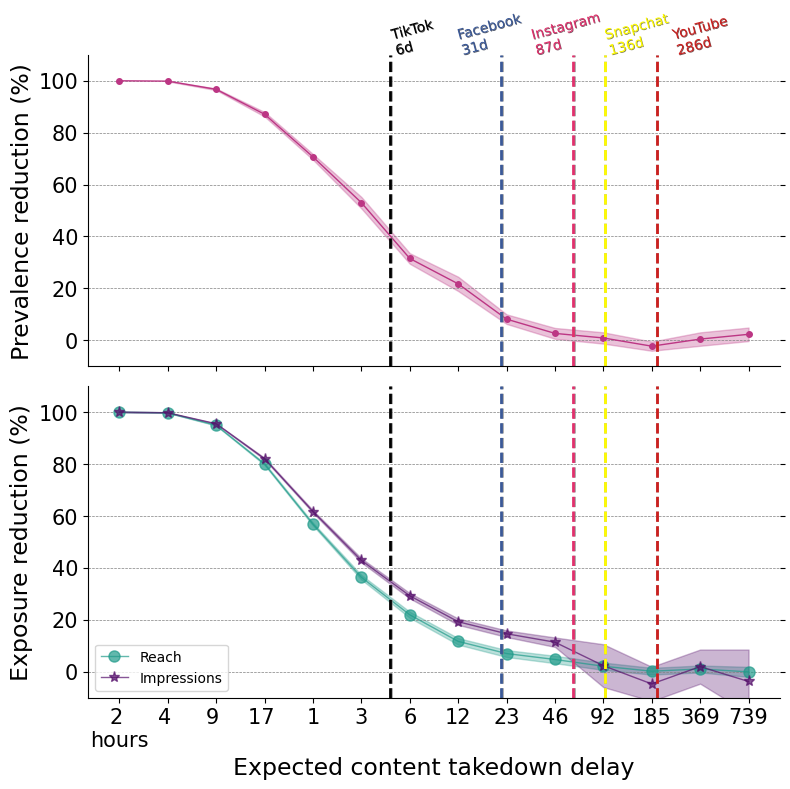

In [ ]:
import matplotlib.pyplot as plt

PALETTE = [
    "#209B8A",  # teal
    "#550F6B",  # purple
    "#3863AC",  # blue
    "#BC3684",  # pink
]
plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"main_res_dsa1year")

x_col = "half_life"
y_labels = ["Prevalence reduction (%)", "Exposure reduction (%)"]
x_label = "Expected content takedown delay"
pct = True
log_x = True

fig, axs = plt.subplots(
    2, 1, figsize=(8, 8), sharex=True, sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# PLOT PREVALENCE
plot_data_prevalence = zip(
    *sorted(
        zip(
            np.array(prevalence_plot_data["x"]) / np.log(2),
            prevalence_plot_data["y"],
            prevalence_plot_data["y_lower"],
            prevalence_plot_data["y_upper"],
        ),
        key=lambda x: x[0],
    )
)
draw_lines(
    axs[0],
    plot_data_prevalence,
    line_name="Prevalence",
    marker=".",
    color=PALETTE[-1],
    absolute=True,
)

## PLOT EXPOSURE
ax = axs[1]
# Define the focal metrics and aggregation types
metrics = [
    ("no_reach", "mean"),
    # ("no_unique_reshares", "mean"),
    ("no_exposures", "mean"),
]
labels = [
    "Reach",
    #   "Engagement",
    "Impressions",
]
markers = ["o", "*", "d"]
lines = ["-", "-", "--"]
metric_col = "pct_mean"
# Plot each focal_metric_agg as a line
idx = 0
xticks = None
# x_tickvalues=None
for focal_metric, agg_type in metrics:
    focal_data = exposure_data[f"{focal_metric}_{agg_type}"]

    x = focal_data["mean_lifetime"]
    if idx == 0:
        xticks = focal_data["human_vals"]
    if labels[idx] == "Impression":
        ax = axs[1]
    y = focal_data[f"{metric_col}"] if not pct else focal_data[f"{metric_col}"] * 100
    y_lower = focal_data["lower"] if not pct else focal_data["lower"] * 100
    y_upper = focal_data["upper"] if not pct else focal_data["upper"] * 100
    plot_data = zip(*sorted(zip(x, y, y_lower, y_upper, xticks), key=lambda x: x[0]))

    # Input: data=(x,y, err)
    x, y, y_lower, y_upper, xticks = plot_data
    # plot absolute values
    y = np.array(y) * -1
    y_lower = np.array(y_lower) * -1
    y_upper = np.array(y_upper) * -1
    ax.plot(
        x,
        y,
        marker=markers[idx],
        color=PALETTE[idx],
        linewidth=1,
        linestyle=lines[idx],
        alpha=0.7,
        label=labels[idx],
    )
    ax.fill_between(
        x,
        y_lower,
        y_upper,
        color=PALETTE[idx],
        alpha=0.3,
    )
    idx += 1

    ax.legend(loc="lower left")


# Additional plot settings
from matplotlib.ticker import FixedLocator, FuncFormatter

for kdx, ax in enumerate(axs):
    # Plot dashed lines at specified values with alternating colors
    half_lives = {
        "TikTok": 4.330755832477102,
        "Facebook": 21.169685437132635,
        "Instagram": 60.17239205413954,
        "Snapchat": 94.12900430900339,
        "YouTube": 198.41224859619473,
    }
    colors = {
        "Snapchat": "#fffc00",
        "Facebook": "#3b5998",
        "Instagram": "#E1306C",
        "YouTube": "#CD201F",
        "TikTok": "#000000",
    }

    # Offset values for overlapping labels
    # x ,y offset
    offsets = [(0, 3), (-10, 3), (-28, 3), (-2, 3), (45, 3)]
    # offsets = [(0, 0), (-35, 3), (-55, 3), (-20, 3), (-5, 3)]

    for jdx, platform in enumerate(half_lives.keys()):
        meanlife_value = half_lives[platform] / np.log(2)
        human_meanlife_value = convert_days_to_nearest_unit(meanlife_value)
        x_offset, y_offset = offsets[jdx]
        label = f"{platform} \n{human_meanlife_value}"
        # plot shadow
        shadow_offset = 0.1 + jdx * 0.2

        ax.axvline(
            x=half_lives[platform] + shadow_offset,
            color="gray",
            linestyle="--",
            linewidth=2,
            alpha=0.7,
        )
        ax.axvline(
            x=half_lives[platform],
            color=colors[platform],
            linestyle="--",
            label=label,
            linewidth=2,
        )

        if kdx == 0:
            text = ax.text(
                # half_lives[platform],
                # ax.get_ylim()[1],
                half_lives[platform] + x_offset,
                ax.get_ylim()[1] + y_offset,
                label,
                rotation=15,
                verticalalignment="bottom",
                fontsize=10,
                color=colors[platform],
            )
            import matplotlib.patheffects as path_effects

            # Add a shadow effect
            text.set_path_effects(
                [path_effects.withSimplePatchShadow(offset=(0.5, -0.5), alpha=0.7)]
            )

    ax.set_xscale("log", base=2)
    ax.set_ylabel(y_labels[kdx])

    if kdx == 1:
        # Setting for exposure plot
        ax.set_xlabel(x_label)

        custom_xticks = x
        # if the x is the first element in xticks contains "hours", keep the same, else remove "hours" from x
        custom_xtick_labels = []
        first_hour = False
        first_day = False
        for idx, xtick in enumerate(xticks):
            if "hours" in xtick and not first_hour:
                custom_xtick_labels.append(xtick)
                first_hour = True
            elif "days" in xtick and not first_day:
                custom_xtick_labels.append(xtick)
                first_day = True
            else:
                custom_xtick_labels.append(xtick.split("\n")[0])

        ## NOTE: Set y-axis limits to eliminate the big CI. DELETE THIS LATER
        ax.set_ylim(-10, 110)

    ax.xaxis.set_major_locator(FixedLocator(custom_xticks))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: custom_xtick_labels[custom_xticks.index(x)])
    )
    if kdx == 0:
        ax.set_xticklabels([])
    ax.tick_params(
        labelleft=True,
        labelright=False,
        left=True,
        right=True,
    )

    # Hide spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.grid(True, axis="y", linestyle="--", linewidth=0.5, color="grey")
plt.tight_layout()

plt.savefig(f"{fpath}.png", dpi=300)
plt.savefig(f"{fpath}.pdf", dpi=300)
plt.show()